In [1]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.linear_model import LinearRegression

from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
import sklearn
from sklearn import pipeline, preprocessing, feature_extraction
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, auc, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from scipy import sparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import scipy
from sklearn.preprocessing import StandardScaler
import pickle
import tqdm
%matplotlib inline
%pylab inline

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [5]:
sklearn.__version__

'0.19.0'

In [3]:
import pandas as pd
import tqdm
import os
import re

def normalize_answer(text):
    """Lower text and remove punctuation and extra whitespace."""
    return ' '.join(re.findall(r"\w+", text)).lower()

def sentence_to_word(sentences):
    sentences_in_words = list()
    for sentence in sentences:
        sentences_in_words.append(normalize_answer(sentence).split())
    return sentences_in_words

def text_to_sentence(text):
    sentences = text.split(".")
    return [s.strip() for s in sentences if s.strip() != '']

def get_max_match_sentance(data_row):
    sentences = text_to_sentence(data_row["paragraph"])
    sentences_in_words = sentence_to_word(sentences)
    question_in_words = sentence_to_word([data_row["question"]])[0]

    max_overlap = None
    max_match_sentance_id = None

    question_words = set(question_in_words)
    list_over = None
    for sentance_id in range(len(sentences_in_words)):
        sentence_words = set(sentences_in_words[sentance_id])
        overlap = len(sentence_words.intersection(question_words))
        if max_overlap is None or overlap > max_overlap:
            max_overlap = overlap
            max_match_sentance_id = sentance_id
            list_over = sentence_words.intersection(question_words)
    part_sent = set(sentences_in_words[max_match_sentance_id]).difference(list_over)
    return sentences[max_match_sentance_id], part_sent

In [4]:
X_train = pd.read_csv('../train_task_b.csv')

In [5]:
X_train['paragraph'] = X_train['paragraph'].apply(lambda x: str(x))
X_train['question'] = X_train['question'].apply(lambda x: str(x))
X_train['answer'] = X_train['answer'].apply(lambda x: str(x))

In [6]:
X_train['t_pred'] = 0
for data_ind in tqdm.tqdm(X_train.index.values):
    full_sentance, part_sentance = get_max_match_sentance(X_train.loc[data_ind])
    s = ''
    for i in part_sentance:
        s += i+' '
    X_train.loc[data_ind, 't_pred'] = s[:-1]
    X_train.loc[data_ind, 'full_t_pred'] = full_sentance

X_train['t_pred'] = X_train['t_pred'].apply(lambda x: str(x))
X_train['full_t_pred'] = X_train['full_t_pred'].apply(lambda x: str(x))



100%|██████████| 50364/50364 [03:35<00:00, 233.35it/s]


In [7]:
# Длины в символах
X_train['paragraph_len_ch'] = X_train['paragraph'].apply(lambda x: len(x))
X_train['question_len_ch'] = X_train['question'].apply(lambda x: len(x))

# Преобразование в список
X_train['paragraph'] = X_train['paragraph'].apply(lambda x: x.lower().split())
X_train['question'] = X_train['question'].apply(lambda x: x.lower().split())
X_train['answer'] = X_train['answer'].apply(lambda x: x.lower().split())

# Длины в словах
X_train['paragraph_len'] = X_train['paragraph'].apply(lambda x: len(x))
X_train['question_len'] = X_train['question'].apply(lambda x: len(x))

tmp = pd.DataFrame(X_train.groupby('paragraph_id')['question_id'].count())
tmp.reset_index(inplace=True)
tmp.columns = ['paragraph_id', 'paragraph_freq']
X_train = pd.merge(X_train, tmp, on=['paragraph_id'], how='left')

In [8]:
rows = []
tmp = X_train.apply(lambda row: [rows.append([row['paragraph_id'], row['question_id'], nn]) 
                         for nn in row.paragraph], axis=1)

In [9]:
tmp = pd.DataFrame(rows)
tmp.columns = ['paragraph_id', 'question_id', 'word']
X_train = pd.merge(tmp, X_train, on=['paragraph_id', 'question_id'], how='left')

In [10]:
def f(x, y):    
    return x in y

In [11]:
X_train['y'] = X_train.apply(lambda x: f(x['word'], x['answer']), axis=1)
X_train['in_t_pred'] = X_train.apply(lambda x: f(x['word'], x['t_pred']), axis=1)
X_train['in_full_t_pred'] = X_train.apply(lambda x: f(x['word'], x['full_t_pred']), axis=1)

In [44]:
X_train.groupby(['paragraph_id', 'question_id']).apply(lambda x:sklearn.metrics.f1_score(x['y'], x['in_t_pred'])).mean()

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.2501143634242449

In [45]:
X_train.groupby(['paragraph_id', 'question_id']).apply(lambda x:sklearn.metrics.f1_score(x['y'], x['in_full_t_pred'])).mean()

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.20777147740933988

In [ ]:
0.2501143634242449 слова из макс предложение без тех, что в пересечении
0.20777147740933988 слова из макс предложения

In [ ]:
0.29347493244022954
0.29887700636585884

In [12]:
X_paragraph_id = X_train['paragraph_id']
X_question_id = X_train['question_id']

del X_train['paragraph_id']
del X_train['question_id']
del X_train['word']
del X_train['paragraph']
del X_train['question']
del X_train['answer']
del X_train['t_pred']
del X_train['full_t_pred']

In [13]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)

folds = []
for itr, ite in group_kfold.split(X_train, X_train.y,X_paragraph_id):
    folds += [[itr, ite]]

In [14]:
y_train = pd.DataFrame(X_train['y'])
del X_train['y']

In [14]:
X_train[:4]

,paragraph_len_ch,question_len_ch,paragraph_len,question_len,paragraph_freq,in_t_pred,in_full_t_pred
0,552,64,82,8,5,False,False
1,552,64,82,8,5,False,True
2,552,64,82,8,5,False,True
3,552,64,82,8,5,False,True


In [15]:
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'logloss'
param['max_depth'] = 7
# param['booster'] = 'dart'
#param['booster'] = 'gblinear'
param['eta'] = 0.1
#param['subsample'] = 1.0
# param["scale_pos_weight"] = 0.5
#param['colsample_bytree'] = 0.7
param['nthread'] = 8
#param['num_class'] =3
#param['alpha'] = 0.00
#param['lambda_bias'] = 0.1
# param['lambda'] = 0
#param['min_child_weight'] = 100

# if param['booster'] == 'gblinear': param['eta'] *= 1e-4
numround = 2000

#LGBM
params = {
    #'task': 'train',
    #'boosting_type': 'gbdt',
    #'objective': 'regression',
    #'metric': {'l2', 'auc'},
    #'num_leaves': 31,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    #'subsample': 0.8,
    #'colsample_bytree': 0.7,
    'objective': 'binary',
    'nthread': -1,
    'learning_rate': 0.1,
    #'min_child_weight': 100,
    #'max_depth': 6
    'num_class': 1
    
}

pred_train = np.zeros(len(y_train))
xgbs = []
sc,sc_mean = [],[]

for itr, ite in folds[:1]:
    ypred = []
    for i in range(1):
               
        param['seed'] = i+1
        
        #xgboost
        '''
        Xdatatrain = xgb.DMatrix(data=X_train.ix[itr, :].values,
                                     label=y_train.ix[itr].values)
        Xdataval = xgb.DMatrix(data=X_train.ix[ite, :].values,
                                     label=y_train.ix[ite].values)

        plst = list(param.items())
        watchlist = [(Xdatatrain, 'train'), (Xdataval, 'eval')]
        bst = xgb.train(plst, Xdatatrain, numround, evals=watchlist, verbose_eval=15)

        
        #rc = ensemble.ExtraTreesClassifier(n_estimators=1300, criterion='gini', max_depth=None, n_jobs=-1)
        #pred_train[ite] = bst.predict(Xdataval)
        #neigh = KNeighborsClassifier(n_neighbors=2)
        #neigh.fit(X_train.ix[itr, :], y_train.ix[itr])
        ypred = bst.predict(Xdataval)
        #ypred = neigh.predict_proba(X_train.ix[ite, :])
        xgbs.append(bst)
        '''
        
        # train
        lgb = lgbm.sklearn.LGBMClassifier(n_estimators=400, seed=0, **params)
        lgb.fit(X_train.ix[itr, :], y_train.ix[itr])
        ypred = lgb.predict_proba(X_train.ix[ite, :])[:, 1]

        '''
        model.fit(X_train.ix[itr, :].values, y_train_cat[itr],
            epochs=60,
            batch_size=1000)
        ypred = model.predict(X_train.ix[ite, :].values)
        '''
    #ypred = sum(ypred) / len(ypred) 0.401408 0.392476
    pred_train[ite] = ypred

    
    sc.append(log_loss(y_train.ix[ite, :], pred_train[ite]))

    
print('XGB: {:.3f} +- {:.3f}'.format(np.mean(sc), np.std(sc)))

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/lightgbm/sklearn.py:282: LGBMDeprecationWarning: The `seed` parameter is de

XGB: 0.170 +- 0.000


In [ ]:
0.170
0.180
0.167

In [63]:
tmp = pd.DataFrame(pred_train > 0.1)
tmp.columns = ['bool_pred']
tmp['pred'] = pd.DataFrame(pred_train)
tmp['paragraph_id'] = X_paragraph_id
tmp['question_id'] = X_question_id
tmp['real'] = y_train

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


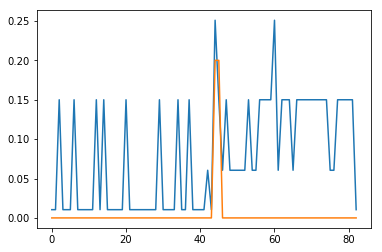

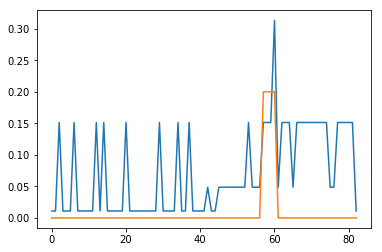

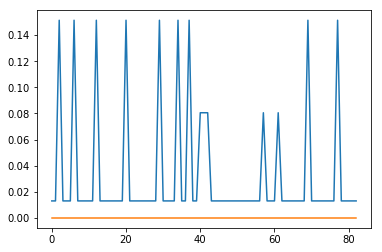

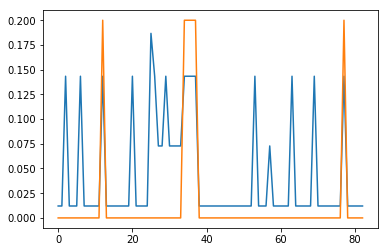

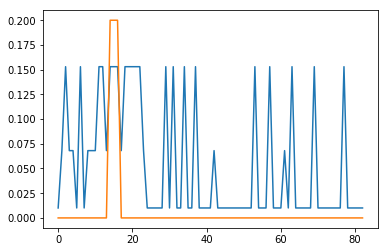

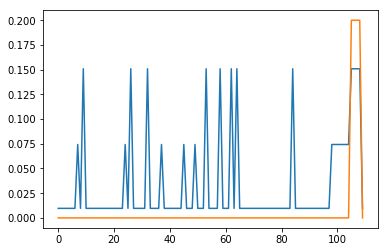

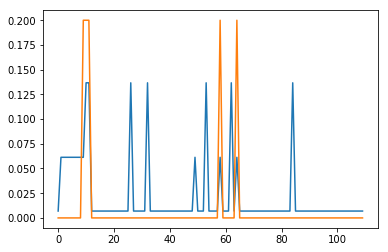

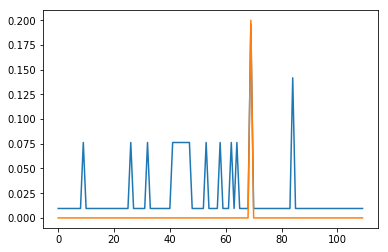

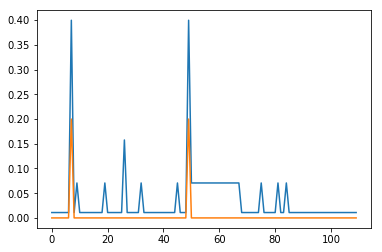

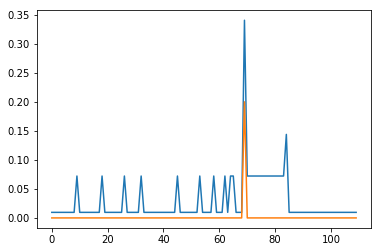

In [104]:
for i in range(100,110):
    curr = tmp[tmp.paragraph_id == pairs.ix[i, 0]][tmp.question_id == pairs.ix[i, 1]]
    plt.plot(range(len(curr)),curr.pred)
    plt.plot(range(len(curr)),curr.real/5.)
    plt.show()

In [92]:
pairs = pd.DataFrame(tmp.groupby(['paragraph_id','question_id'])['pred'].mean())
pairs.reset_index(inplace=True)
pairs = pairs.ix[:,:2]

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
pred_train.mean()

0.052020339715821026

In [61]:
tmp.groupby(['paragraph_id', 'question_id']).apply(lambda x:sklearn.metrics.f1_score(x['real'], x['pred'])).mean()

/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fattahov.ao/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.24596224061315416

In [ ]:
0.2475359265013838
0.2475026840344675

In [16]:
with open('lgb.pickle', 'wb') as f:
    pickle.dump(lgb, f)
with open('lgb.pickle', 'rb') as f:
    lgb = pickle.load(f)

In [141]:
lgb

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=400, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [ ]:
0.29255218542317857
0.2923232603260489
0.29318517279846784 -- simple starter